# Recurrent Neural Networks (RNNs) 
Implementation of simple LSTM and GRU networks

In [4]:
# import external modules
import sys, os
ROOT_PATH = os.path.abspath(".").split("src")[0]
module_path = os.path.abspath(os.path.join(ROOT_PATH+"/src/utils/"))
if module_path not in sys.path:
    sys.path.append(module_path)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib import rc 
from tabulate import tabulate

import keras
from keras import layers, regularizers, Input, Model
from keras.optimizers import RMSprop, Adam, Nadam
from keras.initializers import RandomUniform
from keras import backend as K

import tensorflow as tf
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

import functions as f
import dl_functions as dlf
from generators import batch_generator

In [5]:
# configure matplotlib params and plotting
sns.set()
sns.set_context('paper')
sns.set_style('whitegrid', {'axes.grid': True, 'grid.linestyle': '--'})

rc('figure', figsize=(12,6))
rc('xtick', labelsize=12)
rc('ytick', labelsize=12)
rc('axes', labelsize=13, titlesize=14)
rc('legend', fontsize=14, handlelength=2)
rc('font', family='serif')

SEED=100
np.random.seed(SEED)
tf.set_random_seed(SEED)

## Read and load data

In [6]:
df_train, df_valid, df_test = f.load_data()
#df_train, df_valid, df_test = f.load_data(dummy_data=True, dummy_obs=5000)
stats, ts, ts_train, ts_valid, ts_test = f.load_metadata()

# split datasets into features and targets
x_train, y_train = f.split_dataset(df_train.values, delay=1)
x_valid, y_valid = f.split_dataset(df_valid.values, delay=1)
x_test, y_test = f.split_dataset(df_test.values, delay=1)

# metadata
target_tags = df_train.columns.values[:3]
feature_tags = df_train.columns.values[3:]
target_stds = stats.loc[target_tags,"Std"].values

print(df_train.shape, x_train.shape, y_train.shape)

(53211, 9) (53210, 6) (53210, 3)


## Model evaluation function
This is a function that will evaluate an architecture of a neural network. It will train the model on the training data and return the necessary error metrics for the validation and training data. 

**The inputs to the function (in order):**
* `model` : A keras.models.Model() object. The architecture of the model
* `x_train` : The features of the training data
* `y_train` : The targets of the training data
* `x_valid` : The features of the validation data
* `y_valid` : The targets of the validation data
* `x_test` : The features of the test data
* `y_test` : The targets of the test data
* `name` : The name of the model
* `model_folder` : The path to the folder of the model (root folder to save plots, models etc.)
* `lookback` : The number of time steps to "look back" in the training data. Default=540. 
* `batch_size` : The number of observations in a single batch, obtained by the `batch_generator()`. Default=256. 
* `epochs` : The number of epochs to train. Default=30.
* `loss` : The loss metric to minimise. Default=`mae` - Mean Absolute Error. 
* `optimizer` : The optimizer to use when fitting the models. Default=`Adam()`
* `generator` : The batch generator. Default=`batch_generator()` defined in `main/functions.py`
* `nruns` : The number of runs that the predictions will be averaged over. Default=40,
* `makeplots` : Boolean the model should display plots or not. Default=True. 

**The outputs of the function:**
* Dictionary consisting of 
    * the trained model
    * training history 
    * validation error metrics
    * test error metrics. 

**Description:**

The evaluation function will train the model on the training data and keep track of the weights that gave the minimum error. After all training epochs it will load the weights registered on the best run. The model will then make `n` predict values for the validation and test data using the function `make_n_predictions`. The following parameters are then computed:
* `mean_preds` : The mean predictions for all features for all observations. Shape=(n_obs,n_targets).
* `mean_stds` : The standard deviation of the predictions for all features for all observations. Shape=(n_obs,n_targets)
* `expected_std` : The expected standard deviation. It is the average of `mean_stds`, i.e. the average standard deviation across all predictions for all runs. 
* `expected_mean` : The expected mean. It is the average of `mean_preds`, i.e. the average mean across all predictions for all runs. 
* `maes` : The expected MAE (averaged over `n` runs) for each target. Shape=(n_features)
* `maes_unstd` : The expected _unstandardized_ MAE (averaged over `n` runs). Shape=(n_features)
* `avg_mae` : The average of `maes`, i.e. the mean of the MAEs for all targets. 

All these parameters are calculated both for the validation set and the testing set and then collected in separate dictionaries. The model will print the performance for the validation data and testing data, before returning the trained model, training history, validation error metrics and test error metrics in a dictionary.

In [20]:
def evaluate_model(model_func,train_tuple, valid_tuple, test_tuple,
                   name, target_stds, target_tags,
                   generator_func=batch_generator,n_predictions=50,
                   lookback=300,batch_size=256,epochs=30,makeplots=True):
        
    root_path = os.path.abspath(".").split("src")[0]
    model_folder = root_path + "models/{0}/{1}/".format(name,epochs)
    if not os.path.exists(model_folder):
        print("Creating directory", model_folder)
        os.makedirs(model_folder)
    
    weights_checkpoint = model_folder + "weights.h5".format(name)
    
    callbacks = [
        ModelCheckpoint(
            filepath=weights_checkpoint, monitor='val_loss',verbose=1,
            save_weights_only=True,save_best_only=True
        ),
        
        keras.callbacks.ReduceLROnPlateau(
            monitor = 'loss', factor = 0.5, patience = 3, verbose = 1, min_lr=5e-4,
        )
    ]
    
    train_gen = generator_func(train_tuple[0], train_tuple[1], lookback, batch_size)
    train_steps = len(train_tuple[0]) // batch_size
                      
    validation_data = (np.expand_dims(valid_tuple[0], axis=0),
                       np.expand_dims(valid_tuple[1], axis=0))
    
    model = model_func(train_tuple[0].shape, train_tuple[1].shape)
    model.compile(loss='mae', optimizer=Adam(lr=1e-3))
    history = model.fit_generator(generator=train_gen,
                                  epochs=epochs,
                                  steps_per_epoch=train_steps,
                                  validation_data=validation_data,
                                  callbacks=callbacks)
    
    # plot the training history
    dlf.plot_history(history, model_folder + "history.png".format(name))
    
    # save the model and load the weights of the best epoch 
    model.save(model_folder + "model.h5")
    model.load_weights(weights_checkpoint) 
    
    # evaluate the model on validation/testing data
    # ** Validation data **
    val_dict = dlf.get_model_maes(model, valid_tuple[0], valid_tuple[1], target_stds, n_predictions)
    print(" **** VALIDATION DATA ****")
    print(val_dict['str_table'])
                      
    # ** Testing data **
    test_dict = dlf.get_model_maes(model, test_tuple[0], test_tuple[1], target_stds, n_predictions)
    print(" **** TEST DATA ****")
    print(test_dict['str_table'])
    
    # Save results files
    val_dict['df'].to_pickle(model_folder + "dfval.pkl")
    test_dict['df'].to_pickle(model_folder + "dftest.pkl")

    # If makeplots = True, then plot the predictions with the mean 
    if makeplots: 
        dlf.plot_multiple_predictions(model, x_valid, y_valid, ts_valid, target_tags)
    
    return_dict = {
        'model': model,
        'history': history,
        'validation': val_dict,
        'test': test_dict,
    }
    
    # save dictionary to model folder
    f.save_pickle(obj=return_dict, fpath=model_folder+"model_dict.pkl")
    
    return return_dict

In [21]:
def make_summary_for_dict(model_dict, 
                          valid_tuple=(x_valid, y_valid), 
                          test_tuple=(x_test, y_test), 
                          time_tuple=(ts_valid, ts_test), 
                          target_tags=target_tags, 
                          start_idx=500, 
                          n_obs=6*60):
    
    # print summary of architecture
    model_dict['model'].summary()

    print("\n **** VALIDATION DATA **** \n")
    print(model_dict['validation']['str_table'])

    print("\n **** TEST DATA **** \n")
    print(model_dict['test']['str_table'])
    
    print("\n **** Training vs validation history ****")
    dlf.plot_history(model_dict['history'])
    
    print("\n **** PLOTS ****")
    print(" **** VALIDATION DATA **** \n")
    dlf.plot_multiple_predictions(model_dict['model'], valid_tuple[0], valid_tuple[1], 
                              time_tuple[0], target_tags, start_idx, n_obs, plotCI=False)
    
    print("\n **** TEST DATA **** \n")
    dlf.plot_multiple_predictions(model_dict['model'], test_tuple[0], test_tuple[1], 
                              time_tuple[1], target_tags, start_idx, n_obs, plotCI=False)
    
    print("\n **** PLOTS /W CI INTERVALS ---")
    print(" **** VALIDATION DATA **** \n")
    dlf.plot_multiple_predictions(model_dict['model'], valid_tuple[0], valid_tuple[1], 
                              time_tuple[0], target_tags, start_idx, n_obs, plotCI=True)
    
    print("\n **** TEST DATA **** \n")
    dlf.plot_multiple_predictions(model_dict['model'], test_tuple[0], test_tuple[1], 
                              time_tuple[1], target_tags, start_idx, n_obs, plotCI=True)

# LSTM

In [22]:
def lstm_128(x_shape, y_shape): 
    input_layer = Input(shape=(None,x_shape[-1]))
    layer_1 = layers.LSTM(128,
                         dropout = 0.3,
                         recurrent_dropout = 0.3,
                         return_sequences = True)(input_layer, training=True)

    output_layer = layers.Dense(y_shape[-1])(layer_1)
    
    model = Model(input_layer, output_layer) 
    return model

Creating directory /home/shomeb/h/halvorre/master-thesis/models/lstm_128_1/50/
Epoch 1/50
207/207 [==============================] - 98s 475ms/step - loss: 0.5107 - val_loss: 0.5424

Epoch 00001: val_loss improved from inf to 0.54239, saving model to /home/shomeb/h/halvorre/master-thesis/models/lstm_128_1/50/weights.h5
Epoch 2/50
207/207 [==============================] - 100s 481ms/step - loss: 0.4409 - val_loss: 0.5586

Epoch 00002: val_loss did not improve from 0.54239
Epoch 3/50
207/207 [==============================] - 99s 481ms/step - loss: 0.4232 - val_loss: 0.4629

Epoch 00003: val_loss improved from 0.54239 to 0.46292, saving model to /home/shomeb/h/halvorre/master-thesis/models/lstm_128_1/50/weights.h5
Epoch 4/50
207/207 [==============================] - 99s 480ms/step - loss: 0.4122 - val_loss: 0.4762

Epoch 00004: val_loss did not improve from 0.46292
Epoch 5/50
207/207 [==============================] - 99s 481ms/step - loss: 0.4050 - val_loss: 0.4604

Epoch 00005: val_l

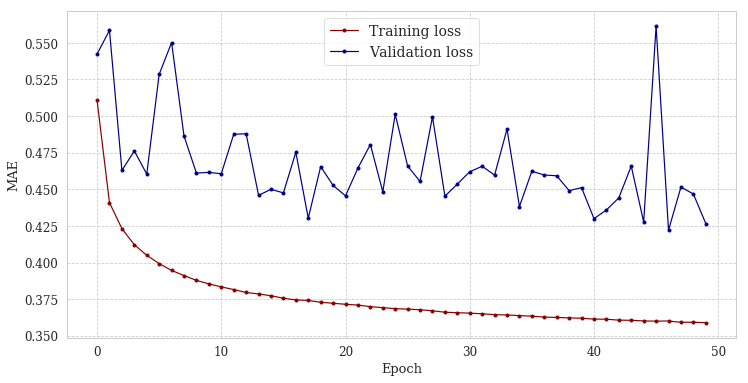

 **** VALIDATION DATA ****
+-----+-------------+---------------+----------------+-----------------+
|     |   MAE (std) |   MAE (unstd) |   Expect. Mean |   Expect. Stdev |
|-----+-------------+---------------+----------------+-----------------|
| FT  |     0.61110 |    2063.50247 |       -0.34929 |         0.20791 |
| TT  |     0.32144 |       0.31389 |        1.19684 |         0.19648 |
| PT  |     0.42985 |       0.10638 |       -0.03688 |         0.16798 |
| Avg |     0.45413 |     687.97425 |        0.27023 |         0.19079 |
+-----+-------------+---------------+----------------+-----------------+
 **** TEST DATA ****
+-----+-------------+---------------+----------------+-----------------+
|     |   MAE (std) |   MAE (unstd) |   Expect. Mean |   Expect. Stdev |
|-----+-------------+---------------+----------------+-----------------|
| FT  |     0.55240 |    1865.26729 |       -0.46720 |         0.21506 |
| TT  |     0.29815 |       0.29115 |        1.57157 |         0.22604 |
| P

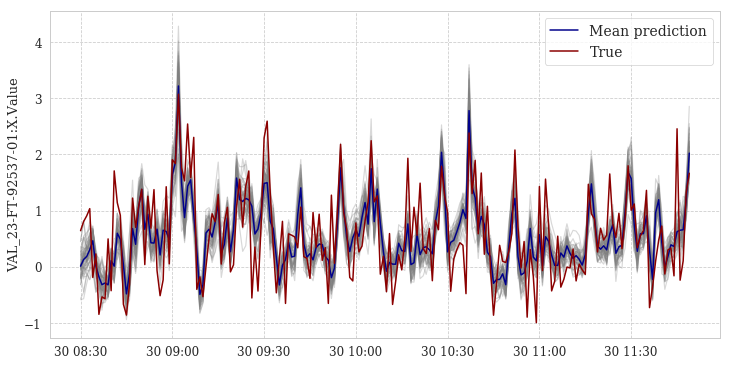

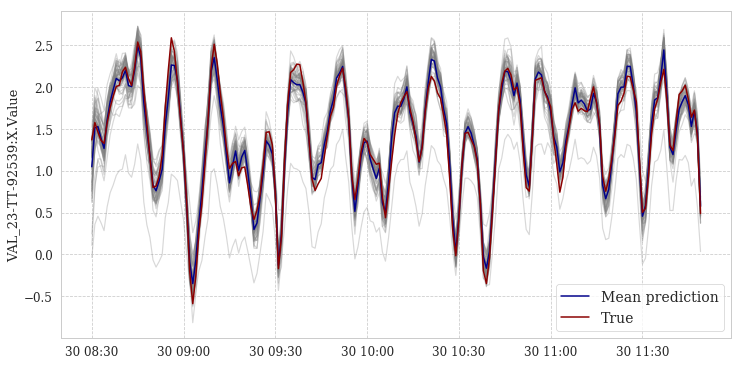

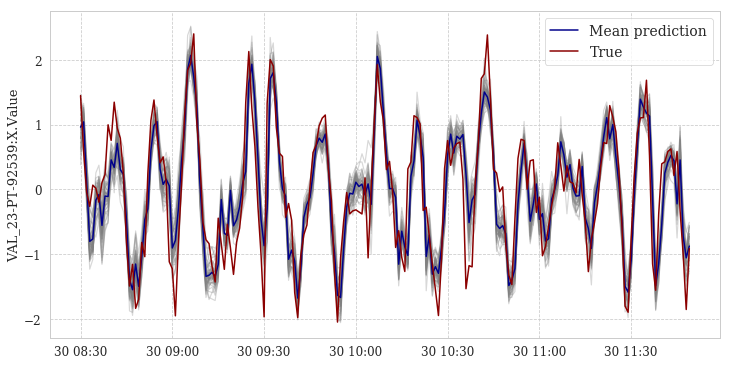

In [23]:
K.clear_session()

name = "lstm_128_1"
n_predictions = 50 
lookback = 6 * 60
batch_size = 256
epochs = 50

lstm_128_dict = evaluate_model(model_func=lstm_128,
                               train_tuple=(x_train, y_train),
                               valid_tuple=(x_valid, y_valid),
                               test_tuple=(x_test, y_test),
                               name=name,
                               target_stds=target_stds,
                               target_tags=target_tags,
                               generator_func=batch_generator,
                               n_predictions=n_predictions,
                               lookback=lookback,
                               batch_size=batch_size,
                               epochs=epochs,
                               makeplots=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, 6)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 128)         69120     
_________________________________________________________________
dense_1 (Dense)              (None, None, 3)           387       
Total params: 69,507
Trainable params: 69,507
Non-trainable params: 0
_________________________________________________________________

 **** VALIDATION DATA **** 

+-----+-------------+---------------+----------------+-----------------+
|     |   MAE (std) |   MAE (unstd) |   Expect. Mean |   Expect. Stdev |
|-----+-------------+---------------+----------------+-----------------|
| FT  |     0.61110 |    2063.50247 |       -0.34929 |         0.20791 |
| TT  |     0.32144 |       0.31389 |        1.19684 |         0.19648 |
| PT  |

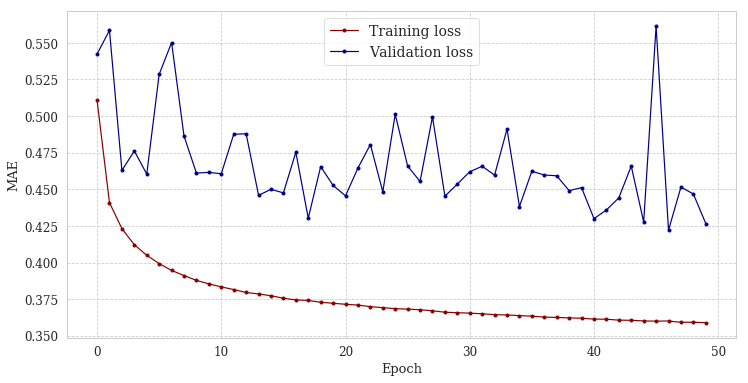


 **** PLOTS ****
 **** VALIDATION DATA **** 



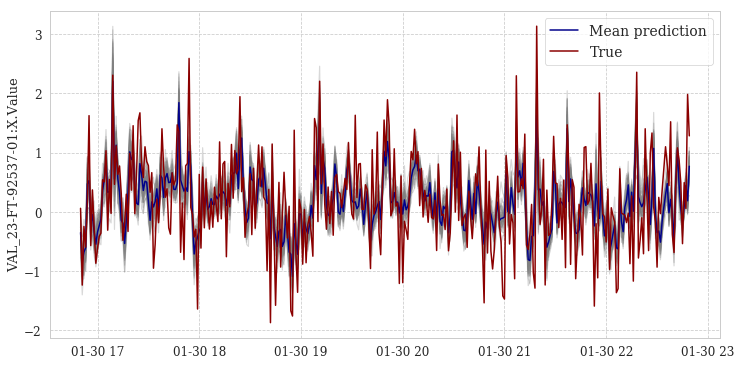

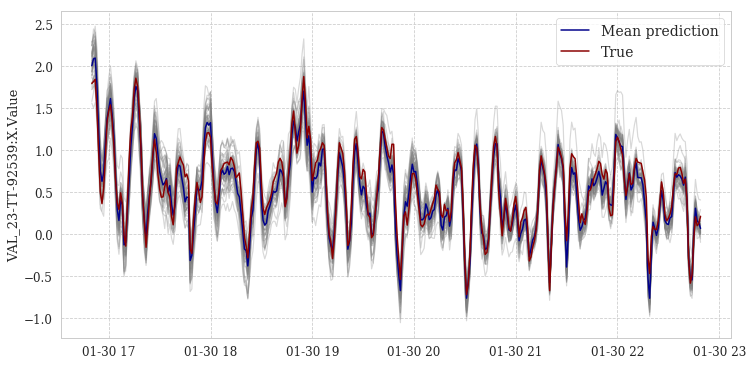

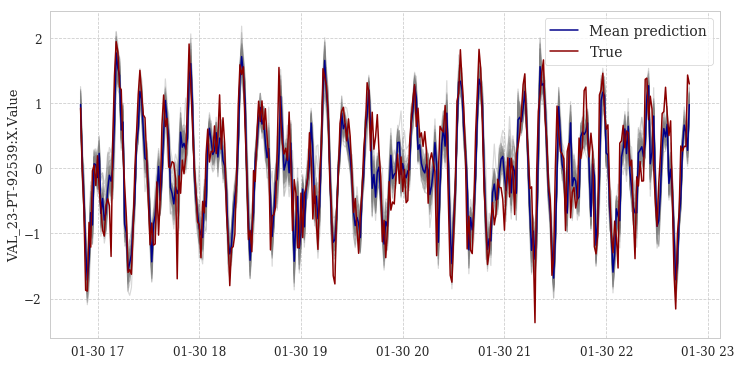


 **** TEST DATA **** 



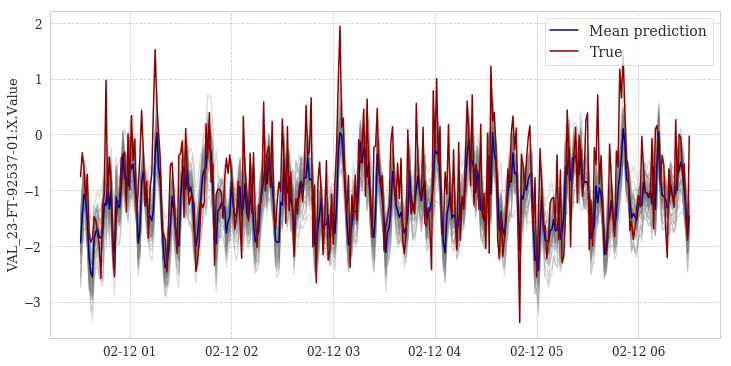

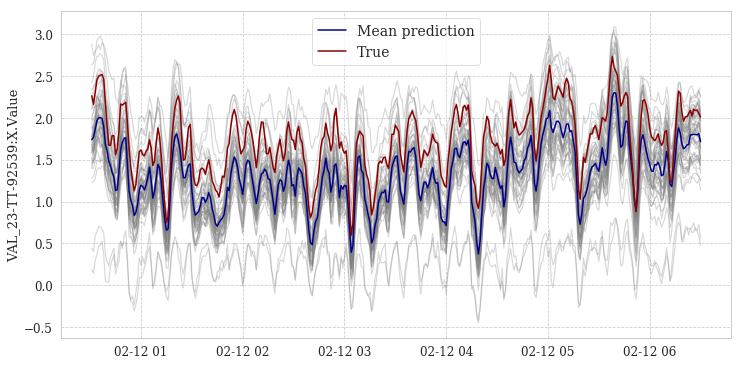

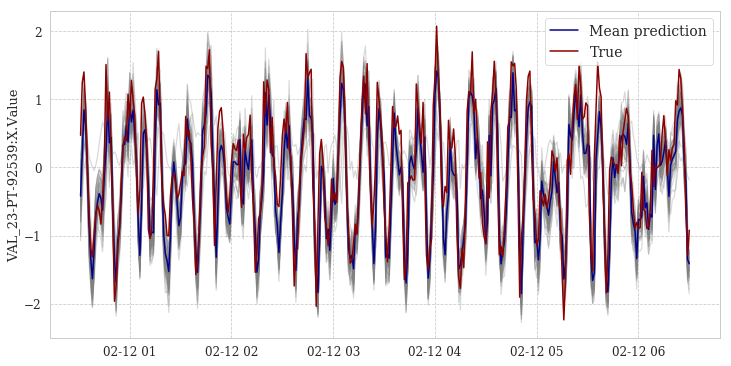


 **** PLOTS /W CI INTERVALS ---
 **** VALIDATION DATA **** 



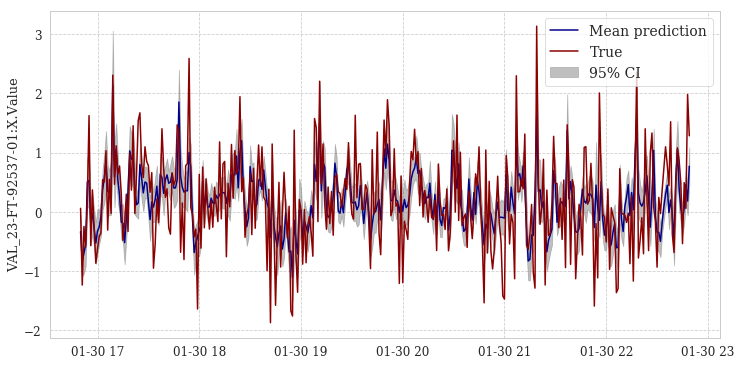

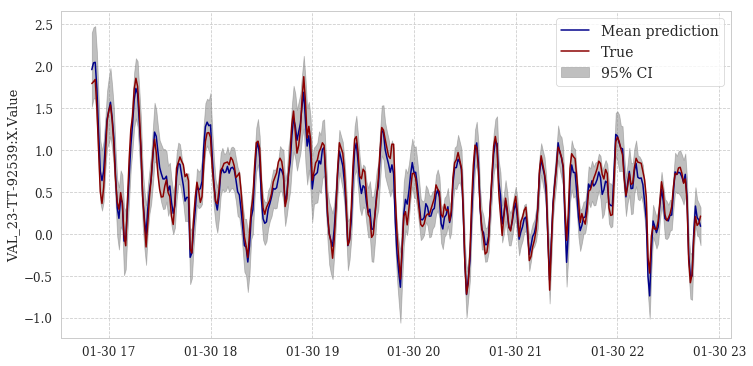

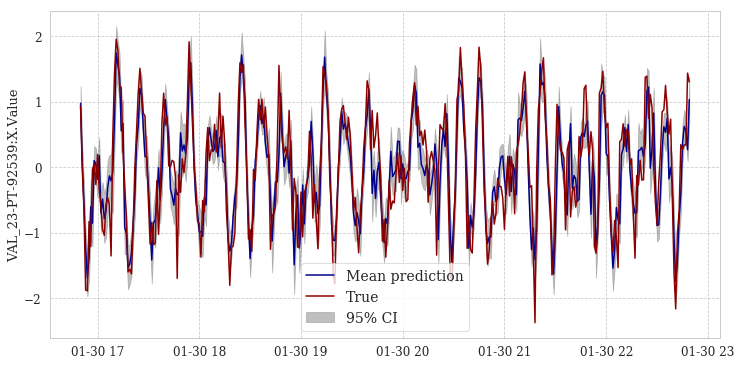


 **** TEST DATA **** 



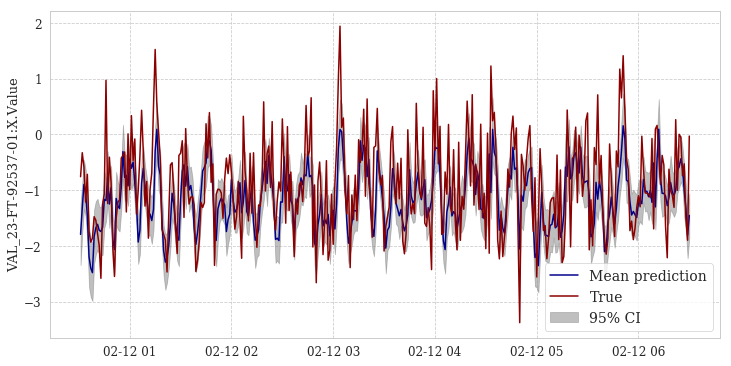

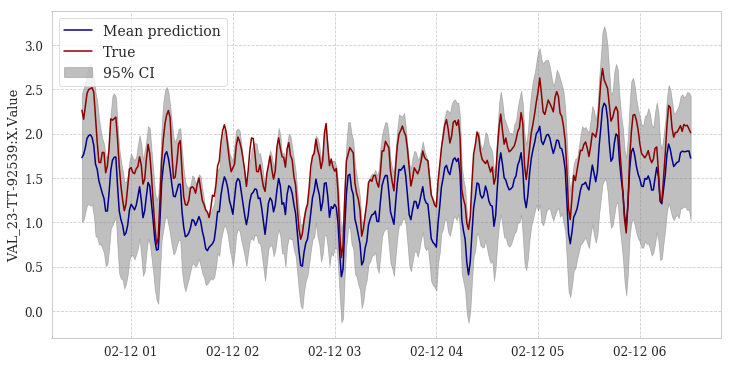

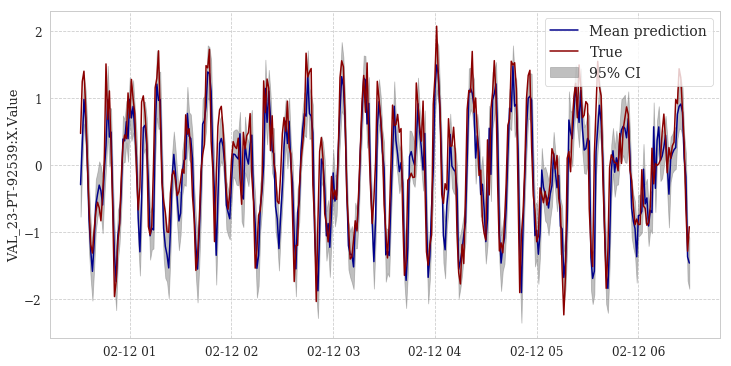

In [24]:
make_summary_for_dict(lstm_128_dict)

# GRU Network

In [25]:
def gru_architecture(x_shape, y_shape): 
    input_layer = Input(shape=(None,x_shape[-1]))
    layer_1 = layers.GRU(128,
                         dropout = 0.3,
                         recurrent_dropout = 0.3,
                         return_sequences = True)(input_layer, training=True)

    output_layer = layers.Dense(y_shape[-1])(layer_1)
    
    model = Model(input_layer, output_layer) 
    return model

In [ ]:
K.clear_session()

name = "gru_128"
n_predictions = 50 
lookback = 6 * 60
batch_size = 256
epochs = 50

gru_128_dict = evaluate_model(model_func=gru_architecture,
                              train_tuple=(x_train, y_train),
                              valid_tuple=(x_valid, y_valid),
                              test_tuple=(x_test, y_test),
                              name=name,
                              target_stds=target_stds,
                              target_tags=target_tags,
                              generator_func=batch_generator,
                              n_predictions=n_predictions,
                              lookback=lookback,
                              batch_size=batch_size,
                              epochs=epochs)

Epoch 1/50
207/207 [==============================] - 92s 442ms/step - loss: 0.5274 - val_loss: 0.5450

Epoch 00001: val_loss improved from inf to 0.54497, saving model to /home/shomeb/h/halvorre/master-thesis/models/gru_128/50/weights.h5
Epoch 2/50
207/207 [==============================] - 91s 441ms/step - loss: 0.4702 - val_loss: 0.5086

Epoch 00002: val_loss improved from 0.54497 to 0.50859, saving model to /home/shomeb/h/halvorre/master-thesis/models/gru_128/50/weights.h5
Epoch 3/50
207/207 [==============================] - 91s 440ms/step - loss: 0.4413 - val_loss: 0.4893

Epoch 00003: val_loss improved from 0.50859 to 0.48934, saving model to /home/shomeb/h/halvorre/master-thesis/models/gru_128/50/weights.h5
Epoch 4/50
207/207 [==============================] - 91s 441ms/step - loss: 0.4290 - val_loss: 0.4941

Epoch 00004: val_loss did not improve from 0.48934
Epoch 5/50
207/207 [==============================] - 91s 441ms/step - loss: 0.4212 - val_loss: 0.4746

Epoch 00005: val

In [ ]:
make_summary_for_dict(gru_128_dict)

# Final results

In [44]:
def evaluate_trained_model(model, valid_tup, test_tup, target_stds=target_stds, n_pred=300, input_dim=3):
    val_dict = dlf.get_model_maes(model, valid_tup[0], valid_tup[1], 
                                  target_stds, n_predictions=n_pred, input_dim=input_dim)
    test_dict = dlf.get_model_maes(model, test_tup[0], test_tup[1], 
                                   target_stds, n_predictions=n_pred, input_dim=input_dim)
    
    return_dict = {
        'validation': val_dict,
        'test': test_dict
    }
    
    return return_dict

In [34]:
valid_tup = (x_valid, y_valid)
test_tup = (x_test, y_test)
n_pred = 300

print("Evaluating LSTM...")
lstm_model = dlf.load_keras_model(ROOT_PATH + "models/lstm_128/50/")
lstm_dict = dlf.evaluate_trained_model(lstm_model, valid_tup, test_tup, n_pred=n_pred)

print("Evaluating GRU...")
gru_model = dlf.load_keras_model(ROOT_PATH + "models/gru_128/50/")
gru_dict = dlf.evaluate_trained_model(gru_model, valid_tup, test_tup, n_pred=n_pred)

Evaluating LSTM...
Evaluating GRU...


In [41]:
# Summary 
dicts = [lstm_dict, gru_dict]
columns=["FT", "TT", "PT", "Avg"]
index = ["LSTM", "GRU"]
summary, tex = dlf.get_df_from_dicts(dicts, columns, index)
print(tex)
print(summary)
print()

# Uncertainty dataframes
dicts = [lstm_dict, gru_dict]
columns=["MAE", "Exp. Mean", "Exp. Std"]
index = ["LSTM", "GRU"]
levels = ["FT","TT","PT","Avg"]

unc_df, tex = dlf.get_uncertainty_df_from_dicts(dicts, columns, index, levels)
print(tex)
print(unc_df)
print()

\begin{tabular}{lcccccccc}
\toprule
{} & \multicolumn{4}{c}{Validation} & \multicolumn{4}{c}{Test} \\
{} &         FT &      TT &      PT &     Avg &      FT &      TT &      PT &     Avg \\
\midrule
\textbf{LSTM} &     0.6042 &  0.3246 &  0.4286 &  0.4525 &  0.5422 &  0.3179 &  0.4153 &  0.4251 \\
\textbf{GRU } &     0.6169 &  0.3355 &  0.4454 &  0.4660 &  0.5526 &  0.3302 &  0.4383 &  0.4403 \\
\bottomrule
\end{tabular}

     Validation                            Test                        
             FT      TT      PT     Avg      FT      TT      PT     Avg
LSTM     0.6042  0.3246  0.4286  0.4525  0.5422  0.3179  0.4153  0.4251
GRU      0.6169  0.3355  0.4454  0.4660  0.5526  0.3302  0.4383  0.4403

\begin{tabular}{llcccccc}
\toprule
    &     & \multicolumn{3}{c}{Validation} & \multicolumn{3}{c}{Test} \\
    &     &        MAE & Exp. Mean & Exp. Std &     MAE & Exp. Mean & Exp. Std \\
\midrule
\multirow{4}{*}{\textbf{LSTM}} & \textbf{FT} &     0.6042 &   -0.3187 &   0.1941 &  0

#### Export results

In [43]:
path = ROOT_PATH + "models/dataframes/"
summary.to_pickle(path + "rnn_summary_df.pkl")
unc_df.to_pickle(path + "rnn_uncertainty_df.pkl")